Loaded 120 synthetic experiments
Methods: ['lasso' 'lassonet' 'nimo_transformer' 'random_forest' 'nimo_baseline'
 'neural_net']
Datasets: ['A' 'B' 'C' 'D']


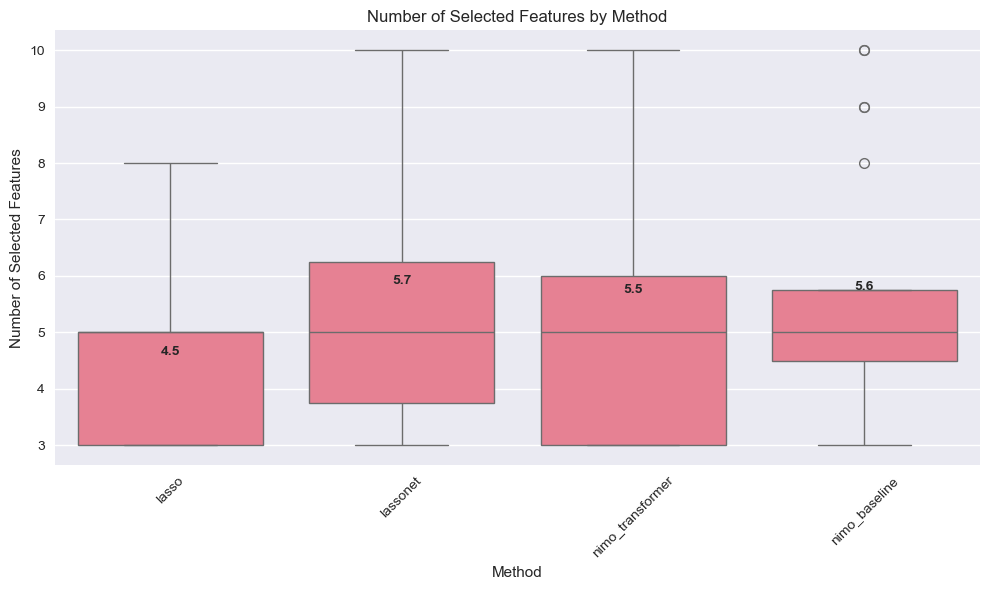

\n=== FEATURE SELECTION SUMMARY (True Feature Selection Methods Only) ===
                  mean   std  min  max
model_name                            
lasso             4.45  1.28    3    8
lassonet          5.70  2.68    3   10
nimo_baseline     5.55  2.35    3   10
nimo_transformer  5.60  2.64    3   10
\n=== EXCLUDED METHODS ===
Neural Network: Uses all features, no feature selection
Random Forest: Uses all features, 'n_selected' based on importance threshold > 0.01
These methods are excluded as they don't perform true feature selection.


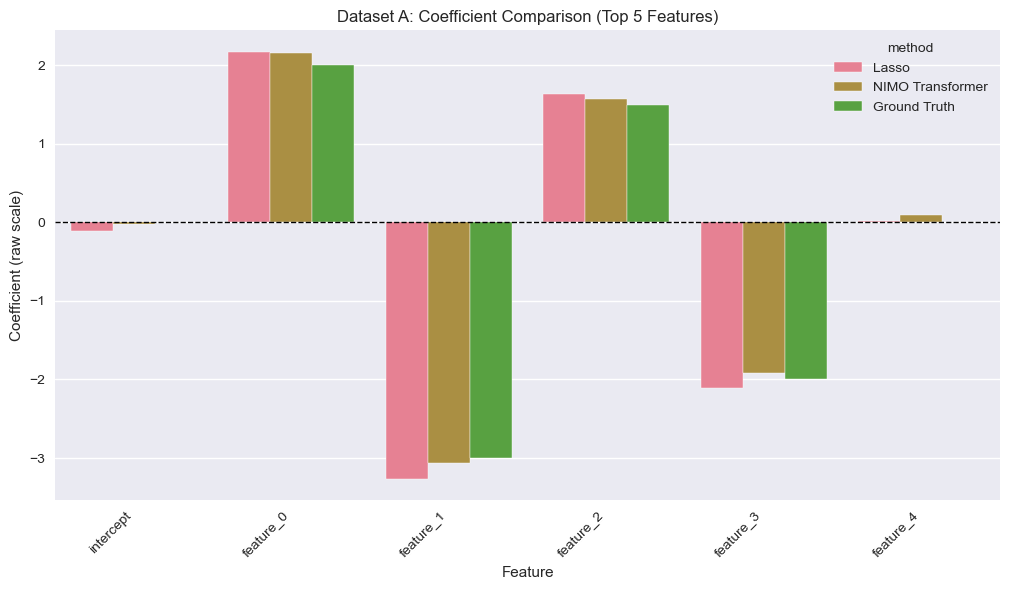

Dataset A Summary:
  True support: [0, 1, 2, 3]
  Lasso: best F1=0.889, selected 5 features -> ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4']
  LassoNet: best F1=0.884, coefficients unavailable, selected 5 features -> ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4']
  NIMO Baseline: best F1=0.878, coefficients unavailable, selected 5 features -> ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4']
  NIMO Transformer: best F1=0.888, selected 5 features -> ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4']


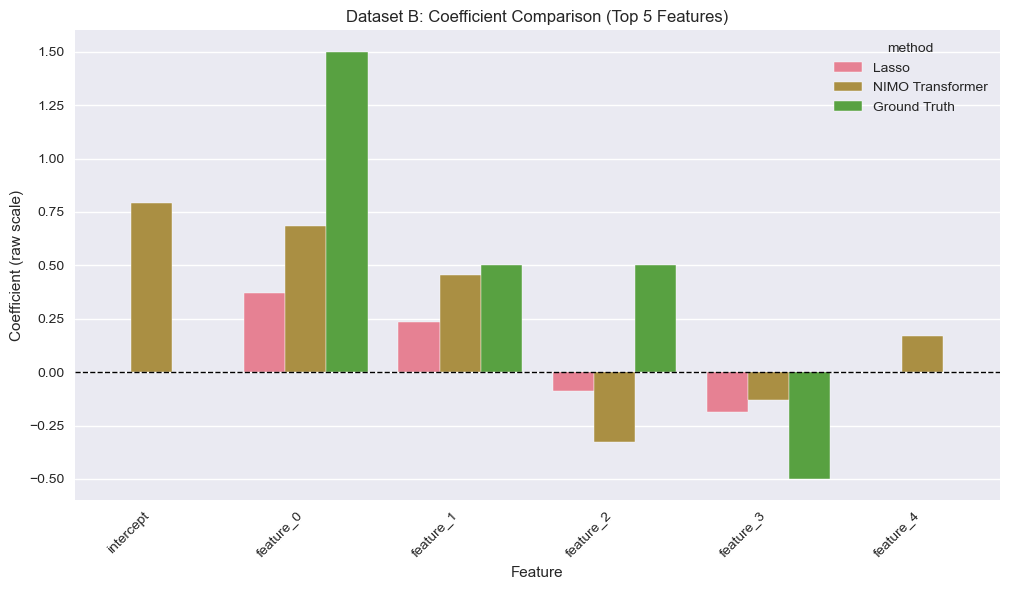

Dataset B Summary:
  True support: [0, 1, 2, 3]
  Lasso: best F1=0.680, selected 5 features -> ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4']
  LassoNet: best F1=0.911, coefficients unavailable, selected 5 features -> ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4']
  NIMO Baseline: best F1=0.671, coefficients unavailable, selected 5 features -> ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4']
  NIMO Transformer: best F1=0.909, selected 5 features -> ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4']


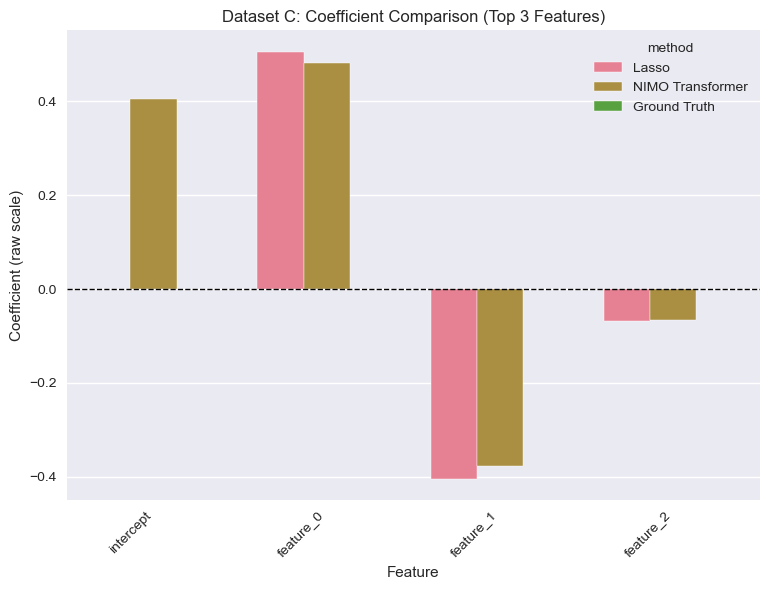

Dataset C Summary:
  True support: []
  Lasso: best F1=0.722, selected 3 features -> ['feature_0', 'feature_1', 'feature_2']
  LassoNet: best F1=0.887, coefficients unavailable, selected 3 features -> ['feature_0', 'feature_1', 'feature_2']
  NIMO Baseline: best F1=0.822, coefficients unavailable, selected 3 features -> ['feature_0', 'feature_1', 'feature_2']
  NIMO Transformer: best F1=0.900, selected 3 features -> ['feature_0', 'feature_1', 'feature_2']


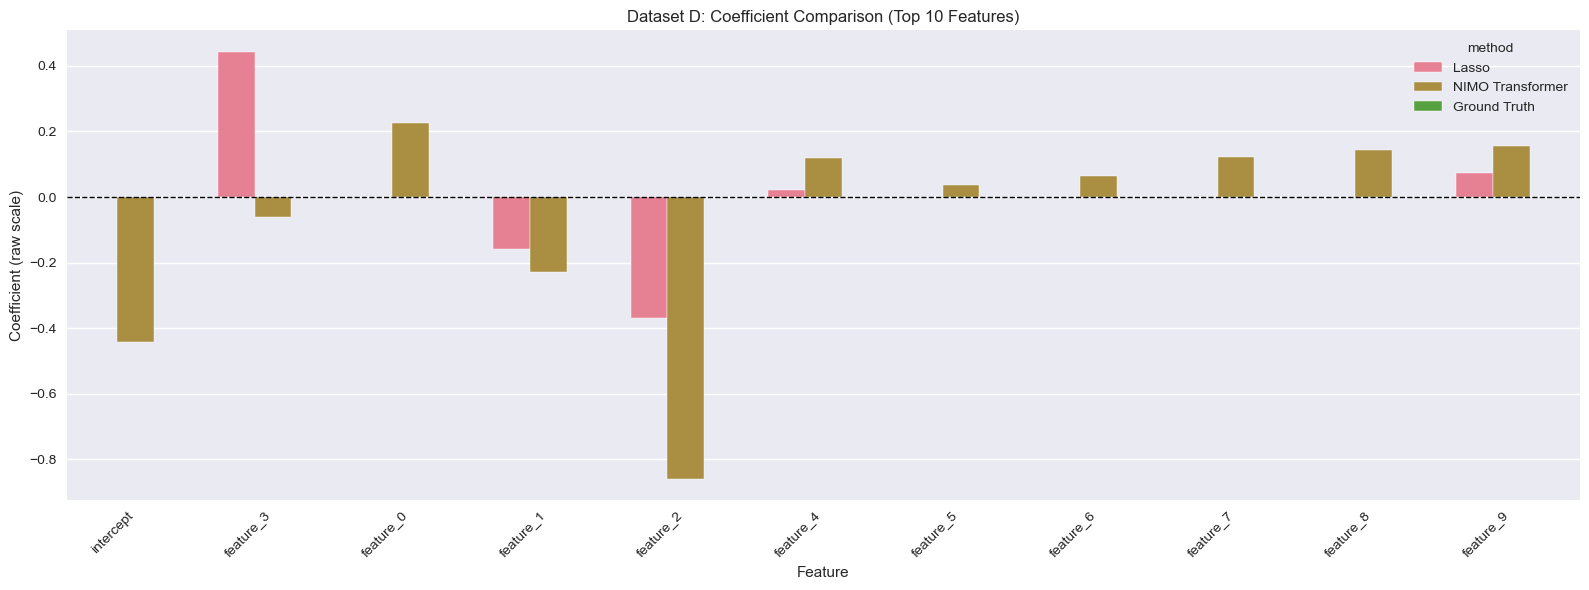

Dataset D Summary:
  True support: [3]
  Lasso: best F1=0.687, selected 5 features -> ['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_9']
  LassoNet: best F1=0.864, coefficients unavailable, selected 10 features -> ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9']
  NIMO Baseline: best F1=0.607, coefficients unavailable, selected 9 features -> ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_6', 'feature_7', 'feature_8', 'feature_9']
  NIMO Transformer: best F1=0.924, selected 10 features -> ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9']


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load data
results_path = Path('../../../results/all/experiment_results.csv')
df = pd.read_csv(results_path)

# Filter for synthetic datasets
synthetic_datasets = ['A', 'B', 'C', 'D', 'E']
df_synthetic = df[df['dataset_id'].isin(synthetic_datasets)]

print(f"Loaded {len(df_synthetic)} synthetic experiments")
print(f"Methods: {df_synthetic['model_name'].unique()}")
print(f"Datasets: {df_synthetic['dataset_id'].unique()}")

# 1. Feature Selection Counts by Method (True Feature Selection Only)
plt.figure(figsize=(10, 6))

# Filter for methods that do true feature selection
feature_selection_methods = ['lasso', 'lassonet', 'nimo_transformer', 'nimo_baseline']
df_feature_selection = df_synthetic[df_synthetic['model_name'].isin(feature_selection_methods)]

# Create boxplot for number of selected features
sns.boxplot(data=df_feature_selection, x='model_name', y='n_selected')
plt.title('Number of Selected Features by Method')
plt.xlabel('Method')
plt.ylabel('Number of Selected Features')
plt.xticks(rotation=45)

# Add mean values as text
means = df_feature_selection.groupby('model_name')['n_selected'].mean()
for i, (method, mean) in enumerate(means.items()):
    plt.text(i, mean + 0.1, f'{mean:.1f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Summary statistics
print("\\n=== FEATURE SELECTION SUMMARY (True Feature Selection Methods Only) ===")
selection_summary = df_feature_selection.groupby('model_name')['n_selected'].agg(['mean', 'std', 'min', 'max']).round(2)
print(selection_summary)

print("\\n=== EXCLUDED METHODS ===")
print("Neural Network: Uses all features, no feature selection")
print("Random Forest: Uses all features, 'n_selected' based on importance threshold > 0.01")
print("These methods are excluded as they don't perform true feature selection.")

import ast

comparison_methods = [
    ("lasso", "Lasso"),
    ("lassonet", "LassoNet"),
    ("nimo_baseline", "NIMO Baseline"),
    ("nimo_transformer", "NIMO Transformer"),
]

TOPK = 20




def _parse_json_like(value, default):
    if value is None:
        return default
    if isinstance(value, (list, dict)):
        return value
    if isinstance(value, str):
        value = value.strip()
        if not value or value.lower() == "nan":
            return default
        try:
            return json.loads(value)
        except Exception:
            try:
                return ast.literal_eval(value)
            except Exception:
                return default
    return default


def _extract_coefficients(row):
    data = _parse_json_like(row.get("coefficients"), {})
    if not isinstance(data, dict):
        return None
    values = data.get("values")
    if values is None:
        return None
    try:
        values = np.asarray(values, dtype=float)
    except Exception:
        values = np.array([], dtype=float)
    feature_names = data.get("feature_names")
    if feature_names is None or len(feature_names) != len(values):
        feature_names = [f"feature_{i}" for i in range(len(values))]
    intercept = float(data.get("intercept", 0.0))
    return {
        "values": values,
        "feature_names": feature_names,
        "intercept": intercept,
    }


def _extract_selected_indices(row, fallback_len=None):
    selected = _parse_json_like(row.get("selected_features"), [])
    if selected and isinstance(selected, list) and all(isinstance(x, (int, np.integer)) for x in selected):
        return selected
    selection_info = _parse_json_like(row.get("selection"), {})
    if isinstance(selection_info, dict):
        mask = selection_info.get("mask")
        if mask is None:
            mask = selection_info.get("indices")
        if mask is not None:
            try:
                mask = list(mask)
                if all(isinstance(m, (int, np.integer)) for m in mask):
                    # assume mask is list of 0/1
                    if max(mask, default=0) <= 1:
                        return [i for i, val in enumerate(mask) if val]
                    return mask
            except Exception:
                pass
    return []


for dataset in synthetic_datasets:
    subset = df_synthetic[df_synthetic["dataset_id"] == dataset]
    if subset.empty:
        continue

    base_row = subset.iloc[0]
    true_support = _parse_json_like(base_row.get("true_support"), [])
    beta_true = _parse_json_like(base_row.get("beta_true"), [])
    n_features = int(base_row.get("n_features_total", len(true_support)))

    beta_true_full = np.zeros(n_features)
    for idx, val in zip(true_support, beta_true):
        if 0 <= idx < n_features:
            beta_true_full[idx] = float(val)

    method_coeffs = {}
    method_rows = {}
    focus_indices = set(true_support)

    for method_id, method_label in comparison_methods:
        mdf = subset[subset["model_name"] == method_id]
        if mdf.empty:
            continue
        best_row = mdf.sort_values("f1", ascending=False).iloc[0]
        method_rows[method_label] = best_row

        selected_idx = _extract_selected_indices(best_row)
        if selected_idx:
            focus_indices.update(selected_idx)

        coeff_info = _extract_coefficients(best_row)
        if coeff_info is None or coeff_info["values"].size == 0:
            continue
        values = coeff_info["values"]
        non_zero = np.where(np.abs(values) > 1e-8)[0]
        focus_indices.update(non_zero.tolist())
        method_coeffs[method_label] = {
            "row": best_row,
            "values": values,
            "feature_names": coeff_info["feature_names"],
            "intercept": coeff_info["intercept"],
            "selected_features": _parse_json_like(best_row.get("selected_features"), []),
        }


    reference_names = None
    for info in method_coeffs.values():
        reference_names = info["feature_names"]
        break
    if reference_names is None:
        reference_names = [f"feature_{i}" for i in range(n_features)]

    focus_core = [idx for idx in true_support if idx < len(reference_names)]
    extra_idx = [idx for idx in sorted(focus_indices) if idx not in focus_core]
    focus_idx = (focus_core + extra_idx)[:TOPK]

    labels = ["intercept"] + [reference_names[idx] if idx < len(reference_names) else f"feature_{idx}" for idx in focus_idx]

    records = []
    for method_label, info in method_coeffs.items():
        coeff_vec = [info["intercept"]]
        for idx in focus_idx:
            if idx < info["values"].size:
                coeff_vec.append(info["values"][idx])
            else:
                coeff_vec.append(0.0)
        for feature, coef in zip(labels, coeff_vec):
            records.append({
                "method": method_label,
                "feature": feature,
                "coef": coef,
            })

    truth_vec = [0.0]
    for idx in focus_idx:
        truth_vec.append(beta_true_full[idx] if idx < beta_true_full.size else 0.0)
    for feature, coef in zip(labels, truth_vec):
        records.append({
            "method": "Ground Truth",
            "feature": feature,
            "coef": coef,
        })

    plot_df = pd.DataFrame(records)

    available_methods = plot_df['method'].unique()
    if len(available_methods) <= 1:
        print(f"Dataset {dataset}: No coefficients available to plot. Showing selection summary only.")
    else:
        plt.figure(figsize=(min(16, 3 + 1.2 * len(labels)), 6))
        sns.barplot(data=plot_df, x="feature", y="coef", hue="method")
        plt.title(f"Dataset {dataset}: Coefficient Comparison (Top {len(labels)-1} Features)")
        plt.xlabel("Feature")
        plt.ylabel("Coefficient (raw scale)")
        plt.xticks(rotation=45, ha='right')
        plt.axhline(0, color='black', linewidth=1, linestyle='--')
        plt.tight_layout()
        plt.show()

    print(f"Dataset {dataset} Summary:")
    print(f"  True support: {true_support}")
    for method_id, method_label in comparison_methods:
        best_row = method_rows.get(method_label)
        if best_row is None:
            continue
        selected = _parse_json_like(best_row.get("selected_features"), [])
        if not selected:
            selected = _extract_selected_indices(best_row)
            selected = [best_row.get("coefficients_feature_names", f"feature_{idx}") for idx in selected]
        coeff_info = method_coeffs.get(method_label)
        if coeff_info:
            print(f"  {method_label}: best F1={best_row['f1']:.3f}, selected {len(selected)} features -> {selected[:10]}")
        else:
            print(f"  {method_label}: best F1={best_row['f1']:.3f}, coefficients unavailable, selected {len(selected)} features -> {selected[:10]}")
    print("=" * 80)

